In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

def calculate_psnr(output, target, max_val=1.0):
    mse = F.mse_loss(output, target)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

class LowLightDataset(Dataset):
    def __init__(self, low_dir, high_dir, transform=None):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.low_images = os.listdir(low_dir)
        self.high_images = os.listdir(high_dir)
        self.transform = transform

        if len(self.low_images) != len(self.high_images):
            print("Warning: The number of images in low_dir and high_dir are not the same.")
            self.low_images = self.low_images[:min(len(self.low_images), len(self.high_images))]
            self.high_images = self.high_images[:min(len(self.low_images), len(self.high_images))]

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_dir, self.high_images[idx])

        low_image = Image.open(low_img_path).convert("RGB")
        high_image = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

transform = transforms.Compose([
    transforms.ToTensor()
])

train_low_dir = '/kaggle/input/dataset00/augmented_Train/augmented/low'
train_high_dir = '/kaggle/input/dataset00/augmented_Train/augmented/high'
val_low_dir = '/kaggle/input/dataset00/augmented_Train/val/low'
val_high_dir = '/kaggle/input/dataset00/augmented_Train/val/high'

train_dataset = LowLightDataset(train_low_dir, train_high_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = LowLightDataset(val_low_dir, val_high_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='bilinear')

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
model = UNet(in_channels=3, out_channels=3)

class MLPBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(MLPBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.gelu(x1)
        x1 = self.conv2(x1)
        x1 = self.sigmoid(x1)
        x = x + x1
        return x

class PixelWarriorNetwork(nn.Module):
    def __init__(self, in_channels=3, num_blocks=6, num_out_channels=3, features=[64, 128, 256, 512]):
        super(PixelWarriorNetwork, self).__init__()
        self.downsampler = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1)
        self.mlp_blocks = nn.ModuleList([MLPBlock(in_channels, in_channels * 2) for _ in range(num_blocks)])
        self.upsampler = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.unet = UNet(in_channels, num_out_channels, features)

    def forward(self, x):
        with autocast():
            x = self.downsampler(x)
            for block in self.mlp_blocks:
                x = block(x)
            x = self.upsampler(x)
            x = self.unet(x)
        return x

model = PixelWarriorNetwork(in_channels=3, num_blocks=6, num_out_channels=3, features=[64, 128, 256, 512])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [2]:
model_path = '/kaggle/input/19march2/vlgmodel2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [9]:
import tqdm

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001)

scaler = GradScaler()
num_epochs = 10

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    for low_images, high_images in train_loader:
        low_images = low_images.to(device)
        high_images = high_images.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(low_images)
            loss = criterion(outputs, high_images)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        psnr = calculate_psnr(outputs, high_images)
        running_psnr += psnr.item()

        del low_images, high_images, outputs, loss, psnr
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader)
    epoch_psnr = running_psnr / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, PSNR: {epoch_psnr:.2f} dB")

    model.eval()
    val_loss = 0.0
    val_psnr = 0.0
    with torch.no_grad():
        for low_images, high_images in val_loader:
            low_images = low_images.to(device)
            high_images = high_images.to(device)

            with autocast():
                outputs = model(low_images)
                loss = criterion(outputs, high_images)

            val_loss += loss.item() * low_images.size(0)
            psnr = calculate_psnr(outputs, high_images)
            val_psnr += psnr.item() * low_images.size(0)

            del low_images, high_images, outputs, loss, psnr
            torch.cuda.empty_cache()

    val_loss /= len(val_loader.dataset)
    val_psnr /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Validation PSNR: {val_psnr:.2f} dB')

    scheduler.step()

torch.save(model.state_dict(), "vlgmodel4.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0191, PSNR: 17.48 dB


 10%|█         | 1/10 [03:04<27:37, 184.17s/it]

Validation Loss: 0.2472, Validation PSNR: 6.11 dB
Epoch [2/10], Loss: 0.0189, PSNR: 17.55 dB


 20%|██        | 2/10 [06:08<24:32, 184.11s/it]

Validation Loss: 0.1252, Validation PSNR: 9.06 dB
Epoch [3/10], Loss: 0.0180, PSNR: 17.72 dB


 30%|███       | 3/10 [09:12<21:28, 184.11s/it]

Validation Loss: 0.0595, Validation PSNR: 12.64 dB
Epoch [4/10], Loss: 0.0174, PSNR: 17.91 dB


 40%|████      | 4/10 [12:16<18:25, 184.23s/it]

Validation Loss: 0.0803, Validation PSNR: 11.06 dB
Epoch [5/10], Loss: 0.0163, PSNR: 18.16 dB


 50%|█████     | 5/10 [15:21<15:21, 184.33s/it]

Validation Loss: 0.1074, Validation PSNR: 10.00 dB
Epoch [6/10], Loss: 0.0159, PSNR: 18.33 dB


 60%|██████    | 6/10 [18:25<12:17, 184.36s/it]

Validation Loss: 0.0315, Validation PSNR: 15.47 dB
Epoch [7/10], Loss: 0.0151, PSNR: 18.50 dB


 70%|███████   | 7/10 [21:29<09:12, 184.31s/it]

Validation Loss: 0.0322, Validation PSNR: 15.44 dB
Epoch [8/10], Loss: 0.0146, PSNR: 18.62 dB


 80%|████████  | 8/10 [24:34<06:08, 184.34s/it]

Validation Loss: 0.0507, Validation PSNR: 13.51 dB
Epoch [9/10], Loss: 0.0142, PSNR: 18.79 dB


 90%|█████████ | 9/10 [27:38<03:04, 184.42s/it]

Validation Loss: 0.0225, Validation PSNR: 16.96 dB
Epoch [10/10], Loss: 0.0136, PSNR: 18.94 dB


100%|██████████| 10/10 [30:43<00:00, 184.31s/it]

Validation Loss: 0.0181, Validation PSNR: 17.91 dB


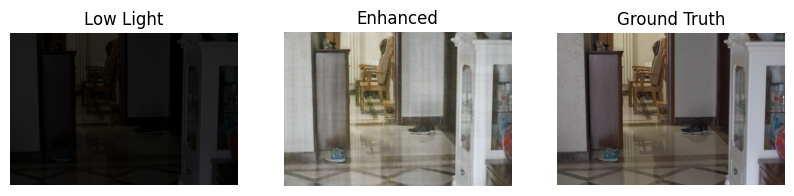

PSNR: 14.97 dB


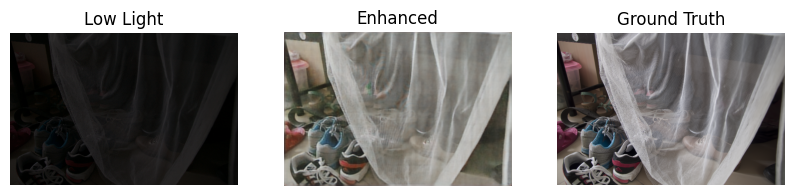

PSNR: 18.94 dB


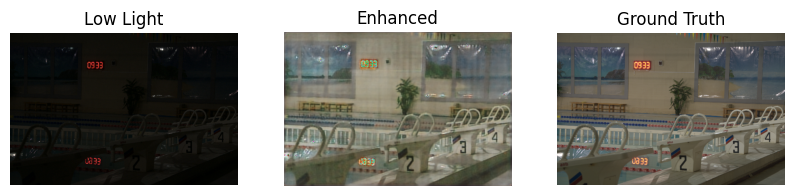

PSNR: 19.57 dB


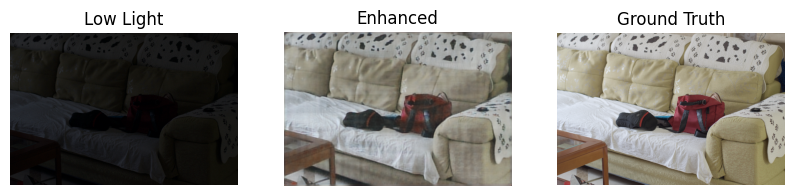

PSNR: 21.03 dB


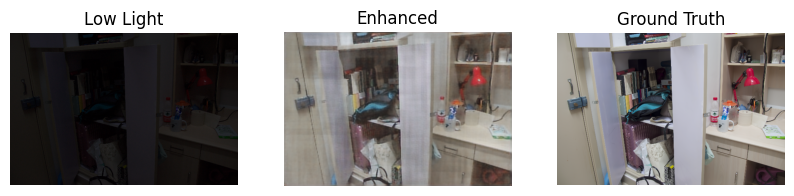

PSNR: 21.13 dB


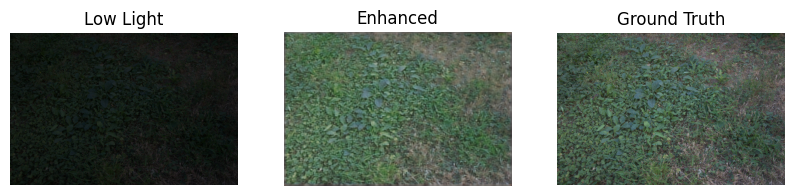

PSNR: 22.85 dB


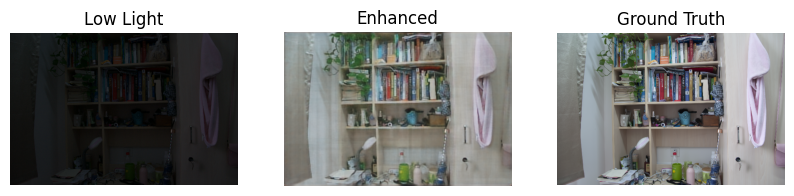

PSNR: 21.17 dB


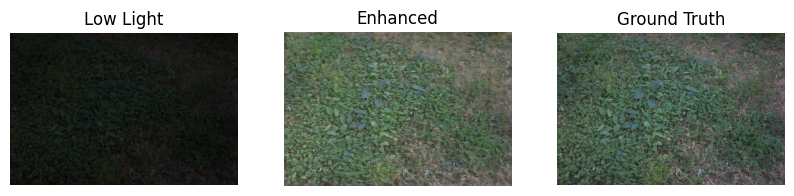

PSNR: 22.31 dB


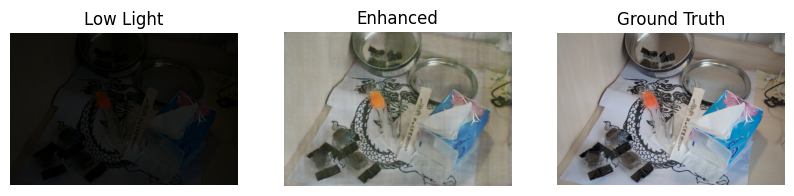

PSNR: 21.36 dB


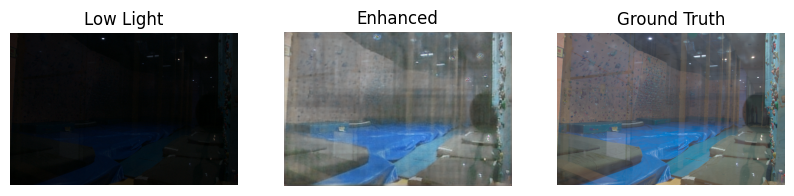

PSNR: 21.11 dB
Average PSNR: 20.44 dB


In [18]:
import torch

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

import random
import cv2
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

# Rest of your code...

model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 592)),
    transforms.ToTensor() 
])
model.eval()

low_dir = '/kaggle/input/dataset00/augmented_Train/val/low'
high_dir = '/kaggle/input/dataset00/augmented_Train/val/high'

low_images = os.listdir(low_dir)

random_images = random.sample(low_images,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

psnr_values = []

for image_name in random_images:
    input_image_path = os.path.join(low_dir, image_name)
    high_image_path = os.path.join(high_dir, image_name)
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = model(input_tensor).cpu()

    enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())

    original_image = cv2.imread(high_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))  
    axs[0].imshow(input_image)
    axs[0].set_title('Low Light')
    axs[0].axis('off')
    
    axs[1].imshow(enhanced_image)
    axs[1].set_title('Enhanced')
    axs[1].axis('off')
    
    axs[2].imshow(original_image_rgb)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    
    plt.show()
    
    original_tensor = transform(Image.fromarray(original_image_rgb)).unsqueeze(0)
    psnr_value = psnr(original_tensor, enhanced_tensor)
    psnr_values.append(psnr_value)
    print(f'PSNR: {psnr_value:.2f} dB')
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')